This program implements an SVM classification method on the ALFA's GPS dataset to develop a Fault Detector and design a sliding window to improve the detector's output stability.

In [20]:
import pandas as pd
import numpy  as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
import matplotlib.pyplot as mplt
from sklearn.metrics import confusion_matrix

GPS = pd.read_excel('Raq_GPS_dataset.xlsx')    # Importing dataset.
GPS


,time,field_header_seq,field_header_stamp,field_twist_linear_x,field_twist_linear_y,field_twist_linear_z,field_twist_angular_x,field_twist_angular_y,field_twist_angular_z,FAULT STATUS
0,1536690000000000000,6821,1536690000000000000,-20.219015,1.119799,0,0,0,0,0
1,1536690000000000000,6822,1536690000000000000,-20.385284,1.004140,0,0,0,0,0
2,1536690000000000000,6823,1536690000000000000,-20.385522,1.186131,0,0,0,0,0
3,1536690000000000000,6824,1536690000000000000,-20.265690,1.484663,0,0,0,0,0
4,1536690000000000000,6825,1536690000000000000,-20.020459,2.097170,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
1045,1536690511872410112,9548,1536690511870749952,-12.130383,-3.794458,0,0,0,0,1
1046,1536690512046810112,9549,1536690512046210048,-12.307983,-3.478168,0,0,0,0,1
1047,1536690512255950080,9550,1536690512255460096,-12.468168,-3.150301,0,0,0,0,1
1048,1536690512449060096,9551,1536690512447849984,-12.616632,-2.829401,0,0,0,0,1


In [21]:
GPS.field_twist_linear_x.describe()

count    1050.000000
mean        1.559078
std        14.009710
min       -23.856790
25%       -12.601650
50%         0.716963
75%        16.969094
max        21.179422
Name: field_twist_linear_x, dtype: float64

In [22]:
GPS.field_twist_linear_y.describe()

count    1050.000000
mean       -0.841898
std        12.248355
min       -23.209600
25%       -11.804684
50%         0.031604
75%         9.143594
max        21.805206
Name: field_twist_linear_y, dtype: float64

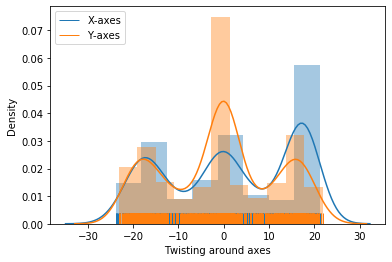

In [23]:
# Data Description.
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.distplot(GPS.field_twist_linear_x, rug=True)
ax = sns.distplot(GPS.field_twist_linear_y, rug=True)
ax.set( xlabel='Twisting around axes',ylabel='Density')#xlabel='Compass Angel',
plt.legend( loc='upper left', labels=['X-axes', 'Y-axes'])
ax.figure.savefig("output2.png")

In [24]:
cols_to_use = ['time', 'field_header_seq', 'field_header_stamp', 'field_twist_linear_x', 'field_twist_linear_y','field_twist_linear_z','field_twist_angular_x','field_twist_angular_y','field_twist_angular_z']
X = GPS[cols_to_use]
y = GPS['FAULT STATUS']
y

0       0
1       0
2       0
3       0
4       0
       ..
1045    1
1046    1
1047    1
1048    1
1049    1
Name: FAULT STATUS, Length: 1050, dtype: int64

In [25]:
 # Separating Train and Test Data.
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=0)
X_valid

,time,field_header_seq,field_header_stamp,field_twist_linear_x,field_twist_linear_y,field_twist_linear_z,field_twist_angular_x,field_twist_angular_y,field_twist_angular_z
743,1536690451474550016,9246,1536690451474149888,-18.945602,1.142169,0,0,0,0
656,1536690367278889984,8825,1536690367276570112,16.713234,0.475601,0,0,0,0
704,1536690376850050048,8873,1536690376849390080,-1.404819,-16.590629,0,0,0,0
738,1536690450461469952,9241,1536690450461050112,-19.856400,0.735042,0,0,0,0
496,1536690335256600064,8665,1536690335255480064,-14.000699,12.456646,0,0,0,0
...,...,...,...,...,...,...,...,...,...
50,1536690000000000000,6871,1536690000000000000,15.653802,-16.728018,0,0,0,0
162,1536690000000000000,6983,1536690000000000000,-20.265983,-11.210510,0,0,0,0
1008,1536690504471689984,9511,1536690504470810112,0.520524,-16.471778,0,0,0,0
320,1536690300054240000,8489,1536690300052859904,17.484349,-2.261512,0,0,0,0


In [27]:
# Calculating the standard deviation and mean of each feature.
m1 = X_valid.time.mean()
s1 = X_valid.time.std()

m2 = X_valid.field_header_seq.mean()
s2 = X_valid.field_header_seq.std()

m3 = X_valid.field_header_stamp.mean()
s3 = X_valid.field_header_stamp.std()

m4 = X_valid.field_twist_linear_x.mean()
s4 = X_valid.field_twist_linear_x.std()

m5 = X_valid.field_twist_linear_y.mean()
s5 = X_valid.field_twist_linear_y.std()

m6 = X_valid.field_twist_linear_z.mean()
s6 = X_valid.field_twist_linear_z.std()

m7 = X_valid.field_twist_angular_x.mean()
s7 = X_valid.field_twist_angular_x.std()

m8 = X_valid.field_twist_angular_y.mean()
s8 = X_valid.field_twist_angular_y.std()

m9 = X_valid.field_twist_angular_z.mean()
s9 = X_valid.field_twist_angular_z.std()

m4

1.9939484044000282

In [28]:
 # Preparing random noise based on standard deviation and mean of each feature.
r1 =1* np.random.normal(m1,s1, X_valid[cols_to_use[0]].shape)
r2 =1* np.random.normal(m2,s2, X_valid[cols_to_use[1]].shape)
r3 =1* np.random.normal(m3,s3, X_valid[cols_to_use[2]].shape)
r4 =1* np.random.normal(m4,s4, X_valid[cols_to_use[3]].shape)
r5 = 1*np.random.normal(m5,s5, X_valid[cols_to_use[4]].shape)
r6 =1* np.random.normal(m6,s6, X_valid[cols_to_use[5]].shape)
r7 = 1*np.random.normal(m7,s7, X_valid[cols_to_use[6]].shape)
r8 = 1*np.random.normal(m8,s8, X_valid[cols_to_use[7]].shape)
r9 = 1*np.random.normal(m9,s9, X_valid[cols_to_use[8]].shape)

f = [r1,r2,r3,r4,r5,r6,r7,r8,r9]
random_noise = np.transpose(f)
random_noise

array([[1.53669061e+18, 8.74907728e+03, 1.53669039e+18, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.53669033e+18, 8.95751633e+03, 1.53669040e+18, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.53669050e+18, 9.12305457e+03, 1.53669040e+18, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.53669040e+18, 8.64254631e+03, 1.53669060e+18, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.53669037e+18, 7.81897602e+03, 1.53669055e+18, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.53669011e+18, 8.89289037e+03, 1.53669037e+18, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [30]:
 # Adding random noise to data.
X_test = X_valid + random_noise
X_test

,time,field_header_seq,field_header_stamp,field_twist_linear_x,field_twist_linear_y,field_twist_linear_z,field_twist_angular_x,field_twist_angular_y,field_twist_angular_z
743,3.073381e+18,17995.077275,3.073381e+18,4.376277,-12.634373,0.0,0.0,0.0,0.0
656,3.073381e+18,17782.516327,3.073381e+18,5.307851,0.531428,0.0,0.0,0.0,0.0
704,3.073381e+18,17996.054569,3.073381e+18,-5.367626,-1.923762,0.0,0.0,0.0,0.0
738,3.073381e+18,17364.557494,3.073381e+18,-11.888873,20.502296,0.0,0.0,0.0,0.0
496,3.073381e+18,17337.651606,3.073381e+18,-6.732412,18.844146,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
50,3.073380e+18,16003.002380,3.073380e+18,30.217413,-23.691927,0.0,0.0,0.0,0.0
162,3.073380e+18,16039.831194,3.073380e+18,-11.742925,-17.105225,0.0,0.0,0.0,0.0
1008,3.073381e+18,18153.546310,3.073381e+18,-4.637573,-20.558284,0.0,0.0,0.0,0.0
320,3.073381e+18,16307.976021,3.073381e+18,35.224678,10.666661,0.0,0.0,0.0,0.0


In [32]:
# Implementing min-max scaling for test and train datasets preprocessing.
minmax_scalextest = preprocessing.MinMaxScaler().fit(X_test)
X_test_minmax = minmax_scalextest.transform(X_test)

minmax_scalextrain = preprocessing.MinMaxScaler().fit(X_train)
X_train_minmax = minmax_scalextrain.transform(X_train)

X_test_minmax

array([[0.95961773, 0.67571026, 0.59637824, ..., 0.        , 0.        ,
        0.        ],
       [0.67956563, 0.63987728, 0.5299614 , ..., 0.        , 0.        ,
        0.        ],
       [0.81765503, 0.67587501, 0.54266091, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.83854804, 0.70242457, 0.82419343, ..., 0.        , 0.        ,
        0.        ],
       [0.65339662, 0.39130305, 0.60193967, ..., 0.        , 0.        ,
        0.        ],
       [0.4730024 , 0.58987284, 0.4635843 , ..., 0.        , 0.        ,
        0.        ]])

In [33]:
 # Implementing the SVM Classiffier.
clf = svm.SVC(kernel='rbf')

clf.fit(X_train_minmax, y_train)
y_pred = clf.predict(X_test_minmax)
print("Accuracy:",metrics.accuracy_score(y_valid, y_pred))

Accuracy: 0.9333333333333333


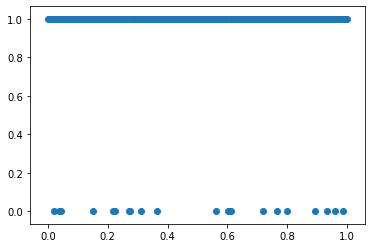

In [35]:
x=np.linspace(0,1,315)
mplt.scatter(x,y_pred)

In [36]:
# Collecting the confusion matrix.
cm = confusion_matrix(y_valid,y_pred)
cm

array([[ 21,  21],
       [  0, 273]], dtype=int64)

In [37]:
# Collecting the Classification Report.
from sklearn.metrics import classification_report
classification_report(y_valid,y_pred)

'              precision    recall  f1-score   support\n\n           0       1.00      0.50      0.67        42\n           1       0.93      1.00      0.96       273\n\n    accuracy                           0.93       315\n   macro avg       0.96      0.75      0.81       315\nweighted avg       0.94      0.93      0.92       315\n'

'              precision    recall  f1-score   support\n\n
           0       1.00      0.50      0.67        42\n
           1       0.93      1.00      0.96       273\n\n
    accuracy                           0.93       315\n   
   macro avg       0.96      0.75      0.81       315\n
weighted avg       0.94      0.93      0.92       315\n'


              Precision  Recall  F1-Score
0                  1.00    0.50      0.67
1                  0.93    1.00      0.96
Macro-Avg          0.96    0.75      0.81
Weighted-Avg       0.94    0.93      0.92


[Text(33.0, 0.5, 'Metrics')]

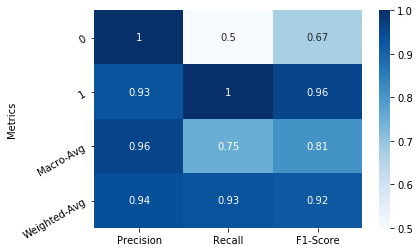

In [53]:
# Plotting the Classification Report.
import pandas as pd
datas = {'Precision':[1.00,0.93,0.96,0.94],'Recall':[0.50,1.00,0.75,0.93],
         'F1-Score':[0.67,0.96,0.81,0.92]}
Indexes=['0','1','Macro-Avg','Weighted-Avg']
rt = pd.DataFrame(datas, index=Indexes)
print(rt)

p1=sns.heatmap(rt, annot=True,cmap='Blues')
p1.set_yticklabels(p1.get_yticklabels(),rotation = 30)
p1.set( ylabel='Metrics')


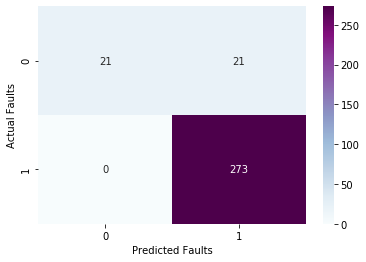

In [49]:
# Plotting the Confusion Matrix.
import seaborn as sns
ax = sns.heatmap(cm, annot=True, fmt="d",cmap="BuPu")
ax.set(xlabel='Predicted Faults', ylabel='Actual Faults')
ax.figure.savefig("Confusion_Matrix_GPS_Dataset.png")

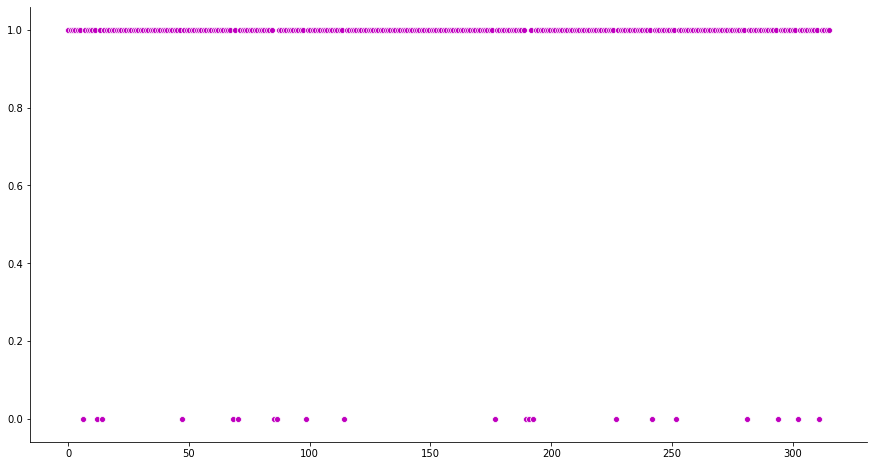

In [57]:
# Plotting the Predicted Output.
import numpy as np
x = np.linspace(0,315,315)
plt.figure(figsize = (15,8))
sns.scatterplot(x, y_pred, color='m')
sns.despine()

In [59]:
# Developing Functions of the Window.
def vectorized_stride_v1(array, clearing_time_index, max_time, sub_window_size,
                         stride_size):       
    start = clearing_time_index + 1 - sub_window_size + 1
    
    sub_windows = (
        start + 
        np.expand_dims(np.arange(sub_window_size), 0) +
        np.expand_dims(np.arange(max_time + 1), 0).T
    )
    
    # Fancy indexing to select every V rows.
    return array[sub_windows[::stride_size]]


def vectorized_stride_v2(array, clearing_time_index, max_time, sub_window_size,
                         stride_size):
    start = clearing_time_index + 1 - sub_window_size + 1
    
    sub_windows = (
        start + 
        np.expand_dims(np.arange(sub_window_size), 0) +
        # Create a rightmost vector as [0, V, 2V, ...].
        np.expand_dims(np.arange(max_time + 1, step=stride_size), 0).T
    )
    
    return array[sub_windows]

In [61]:
# Starting  to implement the Sliding Window over the Output.
z1 = vectorized_stride_v2(y_pred, 1, 314, 5,3)
z1

array([[1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 0, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 0, 1, 0],
       [1, 0, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 0],
       [1, 0, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 0],
       [1, 0, 1, 0, 1],
       [0, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 0, 0],
       [0, 0, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 0],
       [1, 0, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 0, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1,

In [62]:
az = z1.shape
bz = az[0] -1
bz

104

In [65]:
m = np.zeros(bz +1)
m.shape

(105,)

In [66]:
# The Final Step of Sliding Window implementation.
for i in range(0,bz,1):
    er = z1[i]
    ew = np.sum(er)
    
    if ew>2:
        m[i]=1
    else:
        m[i]=0
        
    print(m)

    

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 

In [68]:
m2 = np.zeros(315)
m2.shape

(315,)

In [87]:
# Changing the Sliding Parameters for optimizing the results.
for i in range(0,104,1):
    r1 = i*3
    r2 = r1+4
    for k in range(r1,r2,1):
        m2[k]=m[i]
        

In [90]:
np.sum(m2)

313.0

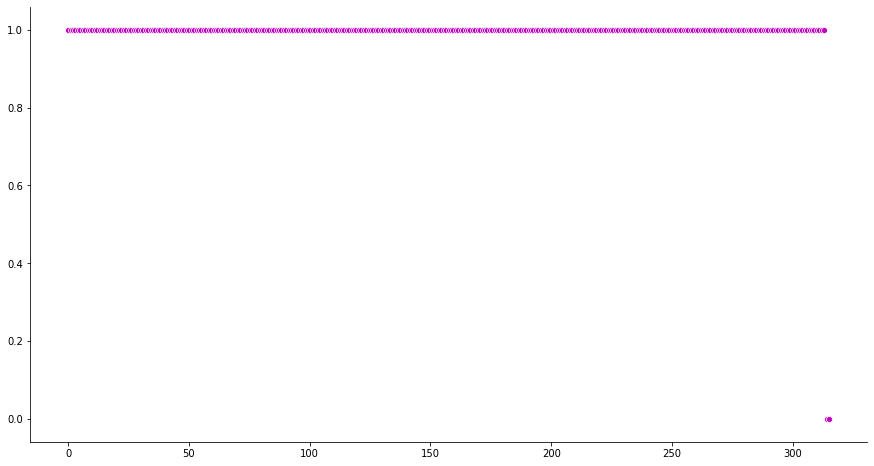

In [91]:
x = np.linspace(0,315,315)
plt.figure(figsize = (15,8))
sns.scatterplot(x, m2,color='m')
sns.despine()

In [92]:
print("Accuracy:",metrics.accuracy_score(y_valid, m2))

Accuracy: 0.8603174603174604


In [110]:
# Changing the Sliding Parameters for optimizing the results.
z2 = vectorized_stride_v2(y_pred, 1, 312, 5,1)
z2

array([[1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       ...,
       [1, 1, 0, 1, 1],
       [1, 0, 1, 1, 1],
       [0, 1, 1, 1, 1]], dtype=int64)

In [111]:
az4 = z2.shape
bz4 = az4[0] -1
bz4

312

In [112]:
m3 = np.zeros(bz4 +1)
m3.shape

(313,)

In [113]:
for i in range(0,bz4,1):
    er = z2[i]
    ew = np.sum(er)
    
    if ew>2:
        m3[i]=1
    else:
        m3[i]=0
        
    print(m3)


[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
[1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 

 0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

In [114]:
m3

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [115]:
m4 = np.zeros(315)
m4.shape

(315,)

In [116]:
# Another Changing the Sliding Parameters for optimizing the results.

for i in range(0,104,1):
    r1 = i*1
    r2 = r1+4
    for k in range(r1,r2,1):
        m4[k]=m[i]
        

In [117]:
np.sum(m4)

107.0

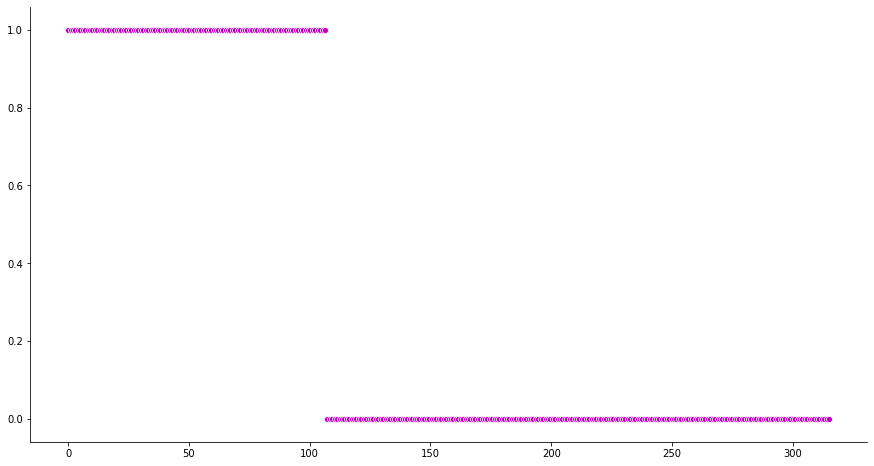

In [119]:
x = np.linspace(0,315,315)
plt.figure(figsize = (15,8))
sns.scatterplot(x, m4,color='m')
sns.despine()

In [120]:
print("Accuracy:",metrics.accuracy_score(y_valid, m4))

Accuracy: 0.37142857142857144
